# 4.3 Анализ данных в индустрии. Проект 1

Для того чтобы отслеживать, как выглядит путь клиента от знакомства с продуктом до его получения, и какие в нем есть проблемные места, аналитики часто строят воронки. Этот инструмент позволяет понять, сколько клиентов "теряется" на каждом из этапов процесса и сколько в итоге совершает целевое действие.

Перед вами схема данных проекта Тинькофф квест. Постройте воронку, которая показывала бы в динамике по неделям и месяцам, сколько клиентов посещает наш сайт, и какая доля из них регистрируется на нем \ подает заявку на игру \ по факту приходит на нее. Количество клиентов и конверсии необходимо изобразить на одном графике.

Какие выводы можно сделать исходя из построенной воронки, какие точки роста продукта вы видите?

Задание нужно выполнить в JupyterNotebook \ Google Colab.

Как выполнять задание:

1. Подключиться к базе данных с помощью Python в JupyterNotebook \ Google Colab 
2. Собрать датасет с необходимыми полями,
3. Посчитать конверсии и сделать визуализацию на Python.
4. Прикрепить файл с выполненным заданием

In [1]:
%pip install psycopg2 pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import psycopg2

Note: you may need to restart the kernel to use updated packages.


In [2]:
config = psycopg2.connect(
    host="158.160.52.106",
    port=5432,
    database="postgres",
    user="student",
    password="JvLda93aA")
cur = config.cursor()

In [3]:
sql = "SELECT DATE_TRUNC('week', visit_dttm) AS week_start, \
            COUNT(DISTINCT c.client_rk) AS num_visitors, \
            COUNT(DISTINCT a.account_rk) AS num_registrations, \
            COUNT(DISTINCT ap.account_rk) AS num_applications, \
            sum(case when g.finish_flg = 1 then 1 else 0 end) AS num_games \
            FROM msu_analytics.client c \
            LEFT JOIN msu_analytics.account a ON c.client_rk = a.client_rk \
            LEFT JOIN msu_analytics.application ap ON a.account_rk = ap.account_rk \
            LEFT JOIN msu_analytics.game g ON g.game_rk = ap.game_rk \
            GROUP BY week_start \
            ORDER BY week_start"

In [4]:
clients_week = pd.read_sql(sql, config)
clients_week

,week_start,num_visitors,num_registrations,num_applications,num_games
0,2022-08-29,111,32,7,3
1,2022-09-05,184,31,6,2
2,2022-09-12,167,43,16,5
3,2022-09-19,181,45,12,12
4,2022-09-26,195,59,17,10
5,2022-10-03,204,58,18,9
6,2022-10-10,190,44,13,9
7,2022-10-17,171,41,12,8
8,2022-10-24,189,48,15,2
9,2022-10-31,197,47,16,14


In [5]:
registrations_percent = clients_week['num_registrations'] / clients_week['num_visitors'] * 100
applications_percent = clients_week['num_applications'] / clients_week['num_visitors'] * 100
games_percent = clients_week['num_games'] / clients_week['num_visitors'] * 100
registrations_percent 

0     28.828829
1     16.847826
2     25.748503
3     24.861878
4     30.256410
5     28.431373
6     23.157895
7     23.976608
8     25.396825
9     23.857868
10    23.699422
11    21.787709
12    27.222222
13    25.423729
14    27.976190
15    26.530612
16    23.958333
17    23.958333
18    28.855721
19    22.926829
20    23.756906
21    22.527473
22    27.160494
dtype: float64

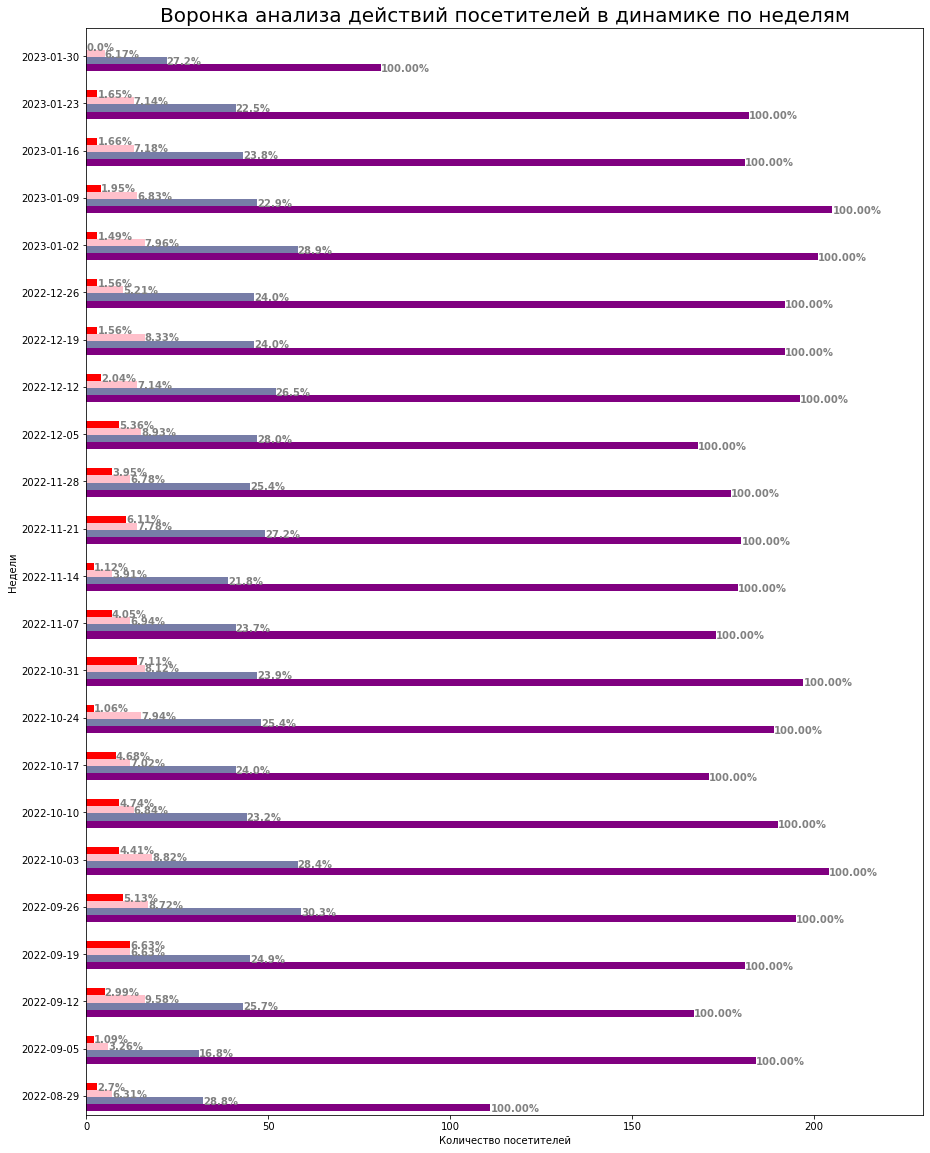

In [6]:
index = np.arange(23)
registrations_percent
applications_percent
games_percent
bw = 0.15
plt.rcParams['figure.figsize'] = [15, 20]
plt.axis([0,230,0,23])
plt.title('Воронка анализа действий посетителей в динамике по неделям', fontsize=20)
plt.barh(index+1*bw, clients_week['num_visitors'], bw, color='purple')
plt.barh(index+2*bw, clients_week['num_registrations'], bw, color='#777DA7')
plt.barh(index+3*bw, clients_week['num_applications'], bw, color='pink')
plt.barh(index+4*bw, clients_week['num_games'], bw, color='r')
plt.xlabel("Количество посетителей")
plt.ylabel("Недели")
legend_list = (
        "Количество посетивших сайт клиентов",
        "Количество зарегистрировавшихся на сайте клиентов",
        "Количество подавших заявку хотя бы на одну игру",
        "Количество посетивших хотя бы одну игру",
    )
plt.yticks(index+0.4,clients_week['week_start'].dt.date)

for i in range(23):
    plt.text(
        clients_week["num_visitors"][i],
        index[i] + 0.5 * bw,
       '100.00%',
        fontsize=10,
        fontweight="bold",
        color="grey",
    )
    
    plt.text(
        clients_week["num_registrations"][i],
        index[i] + 1.5 * bw,
        f"{registrations_percent[i]:.3}%",
        fontsize=10,
        fontweight="bold",
        color="grey",
    )
    
    plt.text(
        clients_week["num_applications"][i],
        index[i] + 2.5 * bw,
        f"{applications_percent[i]:.3}%",
        fontsize=10,
        fontweight="bold",
        color="grey",
    )
    
    plt.text(
        clients_week["num_games"][i],
        index[i] + 3.5 * bw,
        #str(games_percent[i])+'%',
        f"{games_percent[i]:.3}%",
        fontsize=10,
        fontweight="bold",
        color="grey",
    )
plt.show()


In [7]:
sql2 = "SELECT DATE_TRUNC('month', visit_dttm) AS month_start, \
            COUNT(DISTINCT c.client_rk) AS num_visitors, \
            COUNT(DISTINCT a.account_rk) AS num_registrations, \
            COUNT(DISTINCT ap.account_rk) AS num_applications, \
            sum(case when g.finish_flg = 1 then 1 else 0 end) AS num_games \
            FROM msu_analytics.client c \
            LEFT JOIN msu_analytics.account a ON c.client_rk = a.client_rk \
            LEFT JOIN msu_analytics.application ap ON a.account_rk = ap.account_rk \
            LEFT JOIN msu_analytics.game g ON g.game_rk = ap.game_rk \
            GROUP BY month_start \
            ORDER BY month_start"

In [8]:
clients_month = pd.read_sql(sql2, config)
clients_month

,month_start,num_visitors,num_registrations,num_applications,num_games
0,2022-09-01,778,190,51,28
1,2022-10-01,843,217,65,32
2,2022-11-01,786,200,56,39
3,2022-12-01,805,196,57,20
4,2023-01-01,852,213,64,14
5,2023-02-01,32,8,0,0


In [9]:
registrations_percent = clients_month['num_registrations'] / clients_month['num_visitors'] * 100
applications_percent = clients_month['num_applications'] / clients_month['num_visitors'] * 100
games_percent = clients_month['num_games'] / clients_month['num_visitors'] * 100

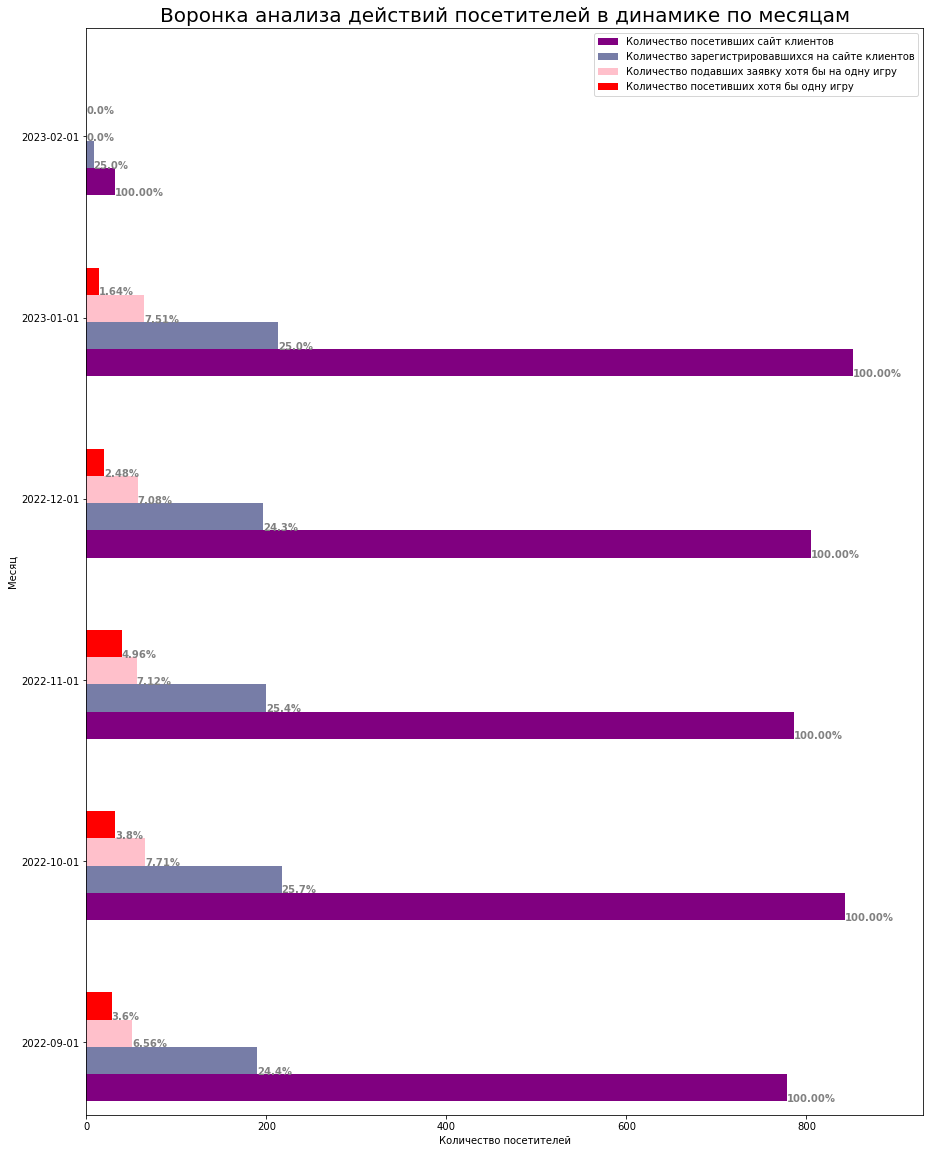

In [10]:
index = np.arange(6)
registrations_percent
applications_percent
games_percent
bw = 0.15
plt.xlabel("Количество посетителей")
plt.ylabel("Месяц")
plt.rcParams['figure.figsize'] = [10, 7]
plt.axis([0,930,0,6])
plt.title('Воронка анализа действий посетителей в динамике по месяцам', fontsize=20)
plt.barh(index+1*bw, clients_month['num_visitors'], bw, color='purple')
plt.barh(index+2*bw, clients_month['num_registrations'], bw, color='#777DA7')
plt.barh(index+3*bw, clients_month['num_applications'], bw, color='pink')
plt.barh(index+4*bw, clients_month['num_games'], bw, color='r')

legend_list = (
        "Количество посетивших сайт клиентов",
        "Количество зарегистрировавшихся на сайте клиентов",
        "Количество подавших заявку хотя бы на одну игру",
        "Количество посетивших хотя бы одну игру",
    )
plt.legend(legend_list)
plt.yticks(index+0.4,clients_month['month_start'].dt.date)
for i in range(6):
    plt.text(
        clients_month["num_visitors"][i],
        index[i] + 0.5 * bw,
       '100.00%',
        fontsize=10,
        fontweight="bold",
        color="grey",
    )
    
    plt.text(
        clients_month["num_registrations"][i],
        index[i] + 1.5 * bw,
        f"{registrations_percent[i]:.3}%",
        fontsize=10,
        fontweight="bold",
        color="grey",
    )
    
    plt.text(
        clients_month["num_applications"][i],
        index[i] + 2.5 * bw,
        f"{applications_percent[i]:.3}%",
        fontsize=10,
        fontweight="bold",
        color="grey",
    )
    
    plt.text(
        clients_month["num_games"][i],
        index[i] + 3.5 * bw,
        #str(games_percent[i])+'%',
        f"{games_percent[i]:.3}%",
        fontsize=10,
        fontweight="bold",
        color="grey",
    )
plt.show()


### Вывод:
Из анализа сайта следует, что:
- Зарегистрироваться на сайте решается лишь 25% посетителей;
- Из них около 33% подают заявку на участие в одной или нескольких играх;
- Из подавших заявку большинство или почти все являются на игры.
Предполагаю, что повышение доли регистраций среди посетителей сайта способствует также увеличению числа заявок на игры и числа участников игр.
Для достижения этой цели можно стимулировать случайных посетителей к регистрации на сайте какими-то преимуществами. Например, упростить процесс регистрации на сайте.